In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from itertools import chain
from sys import platform

vims_wave = np.loadtxt('vims_wave.txt')
new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform =='win32':
    for number in new_array:
        new_string = 'df'+number+' = '+'pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = '+'pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

#Functions for later

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [2]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

spectra_list_f = []
for df in spec_list:
    for spectrum in df:
        fit_spec = single_fit(spectrum)
        spectra_list_f.append(fit_spec)

### What STD's to use? How do we determine what the 'right' amount for the variation is without cutting too much data?

###### Also, might need to fix usage of np.where() function, as documentation says it needs an x,y specification as to what variables its looking at

In [5]:
spectrum_filter_1 = []
ettime_filter_1 = []
for (spectrum,time) in zip(spectra_list_f,time_list_f):
    std = np.std(spectrum)
    ind = np.where((spectrum>=0.5)|(spectrum<=-0.03)) # Center of filter is at 0.265
    if len(ind) == 0 or std<.025:
        spectrum_filter_1.append(spectrum)
        ettime_filter_1.append(time)

print(np.shape(spectrum_filter_1))
print(np.shape(ettime_filter_1))

(12132, 256)
(12132,)


In [6]:
spectrum_filter_2 = []
ettime_filter_2 = []
for (spectrum,time) in zip(spectrum_filter_1,ettime_filter_1):
    std = np.std(spectrum[82:189])
    ind = np.where((spectrum[82:189]>=.01)|(spectrum[82:189]<=-0.005)) # Center of filter is at .0075
    if len(ind) == 0 or std<.0075:
        spectrum_filter_2.append(spectrum)
        ettime_filter_2.append(time)

print(np.shape(spectrum_filter_2))
print(np.shape(ettime_filter_2))

(11880, 256)
(11880,)


In [7]:
spectrum_filter_3 = []
ettime_filter_3 = []
for (spectrum,time) in zip(spectrum_filter_2,ettime_filter_2):
    std = np.std(spectrum[189:230])
    ind = np.where((spectrum[189:230]>=.01)|(spectrum[189:230]<=-.005)) # Center of filter is at .0075, 4 µm window to right before 5 µm jump
    if len(ind) == 0 or std<.0075:
        spectrum_filter_3.append(spectrum)
        ettime_filter_3.append(time)

print(np.shape(spectrum_filter_3))
print(np.shape(ettime_filter_3))

(10560, 256)
(10560,)


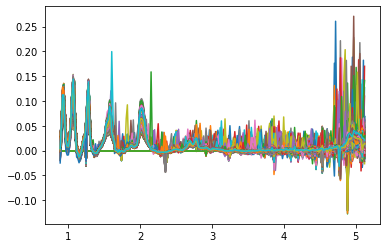

In [8]:
%matplotlib inline
plt.figure(facecolor='white')
for spectrum in spectrum_filter_3:
    plt.plot(vims_wave,spectrum)
plt.show()

In [16]:
spectrum_filter_4 = []
ettime_filter_4 = []
for (spectrum,time) in zip(spectrum_filter_3,ettime_filter_3):
    std = np.std(spectrum[230:256])
    ind = np.where((spectrum[230:256]>=0.06)|(spectrum[230:256]<=0.04)) # Center of filter at .0125
    if len(ind) == 0 or std<.012:
        spectrum_filter_4.append(spectrum)
        ettime_filter_4.append(time)

print(np.shape(spectrum_filter_4))
print(np.shape(ettime_filter_4))
    

(9931, 256)
(9931,)


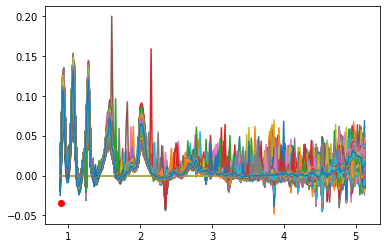

In [17]:
%matplotlib inline
plt.figure(facecolor='white')
for spectrum in spectrum_filter_4:
    plt.plot(vims_wave,spectrum)
plt.plot(vims_wave[1],-.035,marker='o',markeredgecolor='red',markerfacecolor='red') # Show approximate location of the negative max values
plt.show()

### **Idea**: For "cleaning" each of the first few spectral peaks, should we fit a general gaussain to all of the data and exlcude all spectra that lay outside it for each respective window?

In [19]:
spectrum_filter_5 = []
ettime_filter_5 = []
for (spectrum,time) in zip(spectrum_filter_4,ettime_filter_4):
    ind = np.where(spectrum<0)
    if len(ind) >=1:
        spectrum_filter_5.append(spectrum)
        ettime_filter_5.append(time)

print(np.shape(spectrum_filter_5))
print(np.shape(ettime_filter_5))

(9931, 256)
(9931,)
